In [1]:
import matplotlib.pyplot as plt
# import os, sys
import numpy as np
from glob import glob
import pandas as pd
import warnings
from datetime import datetime, timedelta

In [2]:
warnings.filterwarnings("ignore")

In [3]:
logfiles = glob('../test_data/strategy_testing_logs/*/*.log')

In [4]:
logfiles

['../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-collate_butler_wide_csv_vhs_48.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-collate_butler_wide_csv_vhs_4.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-collate_butler_wide_csv_vhs_16.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-compression_butler_wide_csv_vhs_8.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/collate_butler_wide_csv_vhs_4.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-collate_butler_wide_csv_vhs_8.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-compression_butler_wide_csv_vhs_32.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/collate_butler_wide_csv_vhs_48.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/collate_butler_wide_csv_vhs_32.log',
 '../test_data/strategy_testing_logs/test_collate_vs_no-collate/no-co

In [5]:
logs = []
for logfile in logfiles:
    title_name = logfile.split("/")[-1].split(".")[0]
    title_cards = title_name.split("_")
    # Define the regular expression pattern to match the desired lines

    # Lists to store the extracted data
    mbps = np.nan
    sec_per_file = np.nan
    time_for_upload = np.nan
    total_MiB_uploaded = np.nan
    total_files_uploaded = np.nan
    collated = True
    compressed = True
    upload_sizes = []
    upload_times = []
    upload_speeds = []

    with open(logfile, 'r') as lf:
        for line in lf.readlines():
            #Possible lines:
            #Finished at 2024-05-29 20:38:23.761037, elapsed time = 0:00:49.929613
            #Total: 9 files; 4608.00 MiB; 92.29 MiB/s including setup time; 5.55 s/file including setup time
            if 'Finished at' in line:
                total_runtime = datetime.strptime(line.split()[-1], '%H:%M:%S.%f') - datetime(1900, 1, 1, 0, 0, 0, 0)
            elif 'Total:' in line:
                mbps = float(line.split()[5])*8
                sec_per_file = float(line.split()[10])
                total_MiB_uploaded = float(line.split()[3])
                total_files_uploaded = int(line.split()[1])
            elif 'MiB uploaded in' in line:
                upload_sizes.append(float(line.split()[0]))
                upload_times.append(timedelta(seconds = float(line.split()[4])))
                # upload_speeds.append(float(line.split()[6])) # bug in logs - calculated below
    if title_cards[0] == "no-collate":
        collated = False
        compressed = False
    if title_cards[0] == "no-compression":
        compressed = False
    n_procs = int(''.join(filter(str.isdigit,title_cards[-1].split(".")[0])))
    average_upload_time = np.mean(upload_times)

    #something wrong here - average speed appears to be double of total speed
    average_upload_speed = np.mean(np.array(upload_sizes) / (float(average_upload_time.seconds) + float(average_upload_time.microseconds)/1e6))
    mbps = total_MiB_uploaded / (float(total_runtime.seconds) + float(total_runtime.microseconds)/1e6)
    # overheads_time = total_runtime - average_upload_time*total_files_uploaded

    if 'merged' in title_cards:
        if 'vhs' in title_cards:
            ds = 'VHS-merged'
        elif 'video' in title_cards:
            ds = 'VIDEO-merged'
        else:
            ds = 'Unknown'
    elif 'vhs' in title_cards:
            ds = 'CSV-VHS'
    else:
        ds = 'Unknown'

    logs.append({'Title':title_name,
                 'Dataset':ds,
                 'Transfer Speed / MiB/s':mbps,
                 'Seconds per File':sec_per_file,
                 'CPU Count':n_procs,
                 'Average Time per Upload / s':average_upload_time,
                 'Average Speed per Upload / MiB/s':average_upload_speed,
                 'Total Time':total_runtime,
                 'Total MiB Uploaded':total_MiB_uploaded,
                 'Total Files Uploaded':total_files_uploaded,
                #  'Estimated Overheads Time':overheads_time,
                 'Collated':collated,
                 'Compressed':compressed}
                 )

In [6]:
logs

[{'Title': 'no-collate_butler_wide_csv_vhs_48',
  'Dataset': 'CSV-VHS',
  'Transfer Speed / MiB/s': 1010.037334030136,
  'Seconds per File': 0.04,
  'CPU Count': 48,
  'Average Time per Upload / s': datetime.timedelta(seconds=1, microseconds=883393),
  'Average Speed per Upload / MiB/s': 44.86107059629,
  'Total Time': datetime.timedelta(seconds=123, microseconds=887777),
  'Total MiB Uploaded': 125131.28,
  'Total Files Uploaded': 2962,
  'Collated': False,
  'Compressed': False},
 {'Title': 'no-collate_butler_wide_csv_vhs_4',
  'Dataset': 'CSV-VHS',
  'Transfer Speed / MiB/s': 132.62525940755248,
  'Seconds per File': 0.32,
  'CPU Count': 4,
  'Average Time per Upload / s': datetime.timedelta(seconds=1, microseconds=270537),
  'Average Speed per Upload / MiB/s': 66.50024858273187,
  'Total Time': datetime.timedelta(seconds=943, microseconds=495082),
  'Total MiB Uploaded': 125131.28,
  'Total Files Uploaded': 2962,
  'Collated': False,
  'Compressed': False},
 {'Title': 'no-collate_b

In [7]:
logs_df = pd.DataFrame(logs).sort_values(by=['Dataset','CPU Count','Collated','Compressed']).reset_index(drop=True)
# logs_df.drop(logs_df[logs_df['files_per_folder'] == 2].index, inplace=True)
logs_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
0,no-collate_butler_wide_csv_vhs_4,CSV-VHS,132.625259,0.32,4,0 days 00:00:01.270537,66.500249,0 days 00:15:43.495082,125131.28,2962,False,False
1,no-compression_butler_wide_csv_vhs_4,CSV-VHS,135.741531,0.75,4,0 days 00:00:02.241205,68.683595,0 days 00:15:16.172735,124362.69,1220,True,False
2,collate_butler_wide_csv_vhs_4,CSV-VHS,56.135799,1.23,4,0 days 00:00:01.592230,75.934433,0 days 00:24:57.575734,84067.61,1220,True,True
3,no-collate_butler_wide_csv_vhs_8,CSV-VHS,262.200988,0.16,8,0 days 00:00:01.282397,65.885234,0 days 00:07:57.234204,125131.28,2962,False,False
4,no-compression_butler_wide_csv_vhs_8,CSV-VHS,234.282983,0.48,8,0 days 00:00:02.222973,75.631883,0 days 00:08:52.971872,124866.24,1120,True,False
5,collate_butler_wide_csv_vhs_8,CSV-VHS,109.390443,0.69,8,0 days 00:00:01.718473,76.728870,0 days 00:12:50.110331,84242.71,1120,True,True
6,no-collate_butler_wide_csv_vhs_16,CSV-VHS,494.895394,0.09,16,0 days 00:00:01.345952,62.774175,0 days 00:04:12.843897,125131.28,2962,False,False
7,no-compression_butler_wide_csv_vhs_16,CSV-VHS,263.502393,0.44,16,0 days 00:00:02.458529,70.496004,0 days 00:07:54.878343,125131.58,1088,True,False
8,collate_butler_wide_csv_vhs_16,CSV-VHS,214.367255,0.36,16,0 days 00:00:01.687362,80.493810,0 days 00:06:33.427671,84338.01,1088,True,True
9,no-collate_butler_wide_csv_vhs_32,CSV-VHS,817.616105,0.05,32,0 days 00:00:01.588136,53.201380,0 days 00:02:33.044050,125131.28,2962,False,False


In [8]:
noncollated_df = logs_df[logs_df['Collated'] == False]
collated_df = logs_df[logs_df['Collated'] == True]
noncompressed_df = collated_df[collated_df['Compressed'] == False]
compressed_df = collated_df[collated_df['Compressed'] == True]

In [9]:
compressed_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
2,collate_butler_wide_csv_vhs_4,CSV-VHS,56.135799,1.23,4,0 days 00:00:01.592230,75.934433,0 days 00:24:57.575734,84067.61,1220,True,True
5,collate_butler_wide_csv_vhs_8,CSV-VHS,109.390443,0.69,8,0 days 00:00:01.718473,76.728870,0 days 00:12:50.110331,84242.71,1120,True,True
8,collate_butler_wide_csv_vhs_16,CSV-VHS,214.367255,0.36,16,0 days 00:00:01.687362,80.493810,0 days 00:06:33.427671,84338.01,1088,True,True
11,collate_butler_wide_csv_vhs_32,CSV-VHS,307.661802,0.25,32,0 days 00:00:01.855285,73.208265,0 days 00:04:34.125710,84338.01,1088,True,True
14,collate_butler_wide_csv_vhs_48,CSV-VHS,429.599965,0.18,48,0 days 00:00:02.058585,65.978425,0 days 00:03:16.317544,84338.01,1088,True,True
17,collate_butler_wide_csv_vhs_merged_4,VHS-merged,12.904582,0.43,4,0 days 00:00:00.752706,7.359955,0 days 00:00:36.491689,470.91,85,True,True
20,collate_butler_wide_csv_vhs_merged_8,VHS-merged,26.972907,0.26,8,0 days 00:00:00.762059,9.051522,0 days 00:00:17.390413,469.07,68,True,True
23,collate_butler_wide_csv_vhs_merged_16,VHS-merged,43.844432,0.17,16,0 days 00:00:00.830645,8.918643,0 days 00:00:10.476815,459.35,62,True,True
26,collate_butler_wide_csv_vhs_merged_32,VHS-merged,46.141701,0.16,32,0 days 00:00:00.912742,8.116451,0 days 00:00:09.955203,459.35,62,True,True
29,collate_butler_wide_csv_vhs_merged_48,VHS-merged,44.537416,0.17,48,0 days 00:00:01.106613,6.694505,0 days 00:00:10.313800,459.35,62,True,True


In [10]:
noncompressed_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
1,no-compression_butler_wide_csv_vhs_4,CSV-VHS,135.741531,0.75,4,0 days 00:00:02.241205,68.683595,0 days 00:15:16.172735,124362.69,1220,True,False
4,no-compression_butler_wide_csv_vhs_8,CSV-VHS,234.282983,0.48,8,0 days 00:00:02.222973,75.631883,0 days 00:08:52.971872,124866.24,1120,True,False
7,no-compression_butler_wide_csv_vhs_16,CSV-VHS,263.502393,0.44,16,0 days 00:00:02.458529,70.496004,0 days 00:07:54.878343,125131.58,1088,True,False
10,no-compression_butler_wide_csv_vhs_32,CSV-VHS,350.916616,0.33,32,0 days 00:00:02.476599,69.981644,0 days 00:05:56.584939,125131.58,1088,True,False
13,no-compression_butler_wide_csv_vhs_48,CSV-VHS,317.517501,0.36,48,0 days 00:00:02.573879,67.336682,0 days 00:06:34.093490,125131.58,1088,True,False
16,no-compression_butler_wide_csv_vhs_merged_4,VHS-merged,53.279836,0.26,4,0 days 00:00:00.820353,16.676322,0 days 00:00:21.824204,1162.79,85,True,False
19,no-compression_butler_wide_csv_vhs_merged_8,VHS-merged,93.567184,0.18,8,0 days 00:00:00.842059,20.214805,0 days 00:00:12.370897,1157.51,68,True,False
22,no-compression_butler_wide_csv_vhs_merged_16,VHS-merged,94.120566,0.19,16,0 days 00:00:01.039032,17.619222,0 days 00:00:12.059001,1135.00,62,True,False
25,no-compression_butler_wide_csv_vhs_merged_32,VHS-merged,144.241516,0.13,32,0 days 00:00:00.904516,20.239482,0 days 00:00:07.868747,1135.00,62,True,False
28,no-compression_butler_wide_csv_vhs_merged_48,VHS-merged,158.744722,0.12,48,0 days 00:00:01.065806,17.176611,0 days 00:00:07.149844,1135.00,62,True,False


In [11]:
noncollated_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
0,no-collate_butler_wide_csv_vhs_4,CSV-VHS,132.625259,0.32,4,0 days 00:00:01.270537,66.500249,0 days 00:15:43.495082,125131.28,2962,False,False
3,no-collate_butler_wide_csv_vhs_8,CSV-VHS,262.200988,0.16,8,0 days 00:00:01.282397,65.885234,0 days 00:07:57.234204,125131.28,2962,False,False
6,no-collate_butler_wide_csv_vhs_16,CSV-VHS,494.895394,0.09,16,0 days 00:00:01.345952,62.774175,0 days 00:04:12.843897,125131.28,2962,False,False
9,no-collate_butler_wide_csv_vhs_32,CSV-VHS,817.616105,0.05,32,0 days 00:00:01.588136,53.201380,0 days 00:02:33.044050,125131.28,2962,False,False
12,no-collate_butler_wide_csv_vhs_48,CSV-VHS,1010.037334,0.04,48,0 days 00:00:01.883393,44.861071,0 days 00:02:03.887777,125131.28,2962,False,False
15,no-collate_butler_wide_csv_vhs_merged_4,VHS-merged,16.442621,0.17,4,0 days 00:00:00.653918,8.344377,0 days 00:01:09.024884,1134.95,416,False,False
18,no-collate_butler_wide_csv_vhs_merged_8,VHS-merged,28.773763,0.09,8,0 days 00:00:00.737861,7.395076,0 days 00:00:39.443920,1134.95,416,False,False
21,no-collate_butler_wide_csv_vhs_merged_16,VHS-merged,43.719958,0.06,16,0 days 00:00:00.844207,6.463508,0 days 00:00:25.959540,1134.95,416,False,False
24,no-collate_butler_wide_csv_vhs_merged_32,VHS-merged,57.651718,0.05,32,0 days 00:00:01.418654,3.846279,0 days 00:00:19.686317,1134.95,416,False,False
27,no-collate_butler_wide_csv_vhs_merged_48,VHS-merged,58.609183,0.05,48,0 days 00:00:02.015769,2.706926,0 days 00:00:19.364713,1134.95,416,False,False


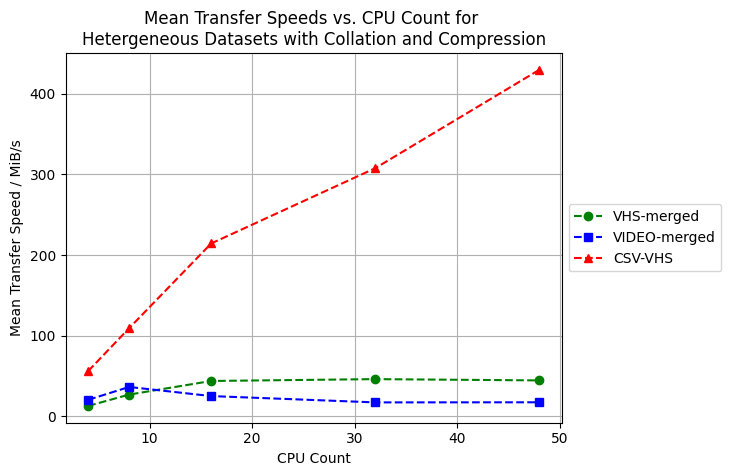

In [12]:
# Plot the mean transfer speeds against file size
plt.plot(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Transfer Speed / MiB/s'], marker='o', linestyle='--', color='g', label='VHS-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['Transfer Speed / MiB/s'], marker='s', linestyle='--', color='b', label='VIDEO-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['Transfer Speed / MiB/s'], marker='^', linestyle='--', color='r', label='CSV-VHS')
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('CPU Count')
plt.ylabel('Mean Transfer Speed / MiB/s')
plt.title('Mean Transfer Speeds vs. CPU Count for \nHetergeneous Datasets with Collation and Compression') 
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Total Time']

17   0 days 00:00:36.491689
20   0 days 00:00:17.390413
23   0 days 00:00:10.476815
26   0 days 00:00:09.955203
29   0 days 00:00:10.313800
Name: Total Time, dtype: timedelta64[ns]

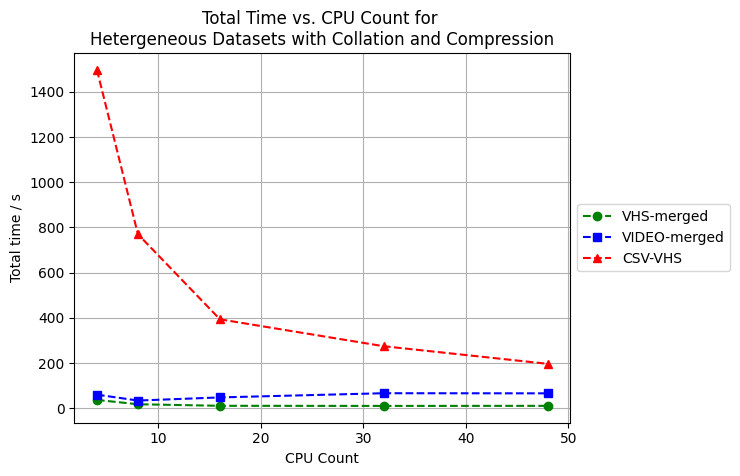

In [14]:
times = []
for dataset in ['VHS-merged', 'VIDEO-merged', 'CSV-VHS']:
    a = []
    for i in range(0, len(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Total Time'])):
        a.append(compressed_df[compressed_df['Dataset'] == dataset]['Total Time'].iloc[i].seconds + compressed_df[compressed_df['Dataset'] == dataset]['Total Time'].iloc[i].microseconds/1e6)
    times.append(a)
# Plot the mean transfer speeds against file size
plt.plot(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['CPU Count'], times[0], marker='o', linestyle='--', color='g', label='VHS-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['CPU Count'], times[1], marker='s', linestyle='--', color='b', label='VIDEO-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['CPU Count'], times[2], marker='^', linestyle='--', color='r', label='CSV-VHS')
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('CPU Count')
plt.ylabel('Total time / s')
plt.title('Total Time vs. CPU Count for \nHetergeneous Datasets with Collation and Compression') 
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

compressed_df
noncompressed_df
noncollated_df


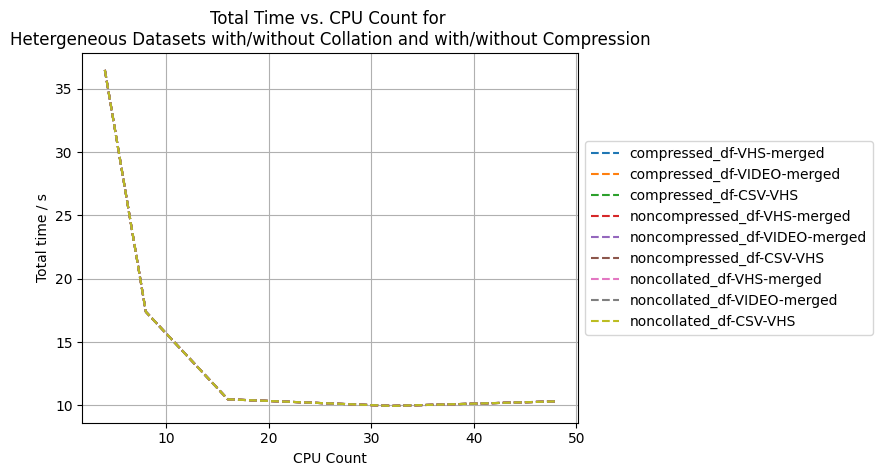

In [21]:
times = []
fig, ax = plt.subplots()
for df in compressed_df, noncompressed_df, noncollated_df:
    df_name = [name for name, value in globals().items() if value is df and not name.startswith('_')][0]
    print(df_name)
    for dataset in ['VHS-merged', 'VIDEO-merged', 'CSV-VHS']:
        a = []
        for i in range(0, len(df[df['Dataset'] == 'VHS-merged']['Total Time'])):
            a.append(df[df['Dataset'] == dataset]['Total Time'].iloc[i].seconds + df[df['Dataset'] == dataset]['Total Time'].iloc[i].microseconds/1e6)
        times.append(a)
        # print(len(df[df['Dataset'] == 'VHS-merged']['CPU Count']))
        # print(len(times[0]))
        ax.plot(df[df['Dataset'] == 'VHS-merged']['CPU Count'], times[0], linestyle='--', label=f"{df_name}-{dataset}")
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('CPU Count')
plt.ylabel('Total time / s')
plt.title('Total Time vs. CPU Count for \nHetergeneous Datasets with/without Collation and with/without Compression') 
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()